In [42]:
# run on pth-gpu on HP Omen
# pth in FUM
# -*- coding: utf-8 -*-
import pickle as pkl
import pandas as pd
import numpy as np
import math
import os
import numpy.linalg as la
from input_data import preprocess_data,load_sz_data,load_los_data

from visualization import plot_result,plot_error
from sklearn.metrics import mean_squared_error,mean_absolute_error
#import matplotlib.pyplot as plt
import time

from dagma import utils
from dagma.linear import DagmaLinear
from dagma.nonlinear import DagmaMLP, DagmaNonlinear
import networkx as nx
import matplotlib.pyplot as plt


time_start = time.time()
###### Settings ######
data_name = 'sz' # 'los'#'los'

###### load data ######
if data_name == 'sz':
    data, adj = load_sz_data('sz')
    # Drop the first 11 days
    data = data.drop(data.index[:1056])
if data_name == 'los':
    data, adj = load_los_data('los')

time_len = data.shape[0]
num_nodes = data.shape[1]
data1 =np.mat(data,dtype=np.float32)

#### normalization
max_value = np.max(data1)
data1 = data1/max_value

In [43]:
# !pip install dagma
# !pip install networkx


In [44]:
type(adj[0,0]), adj.shape, type(adj)

(numpy.int64, (156, 156), numpy.matrix)

In [45]:
G = nx.from_numpy_array(adj, create_using=nx.DiGraph)

# Check if the graph is a DAG
is_dag = nx.is_directed_acyclic_graph(G)

print("The graph is a DAG:", is_dag)

The graph is a DAG: False


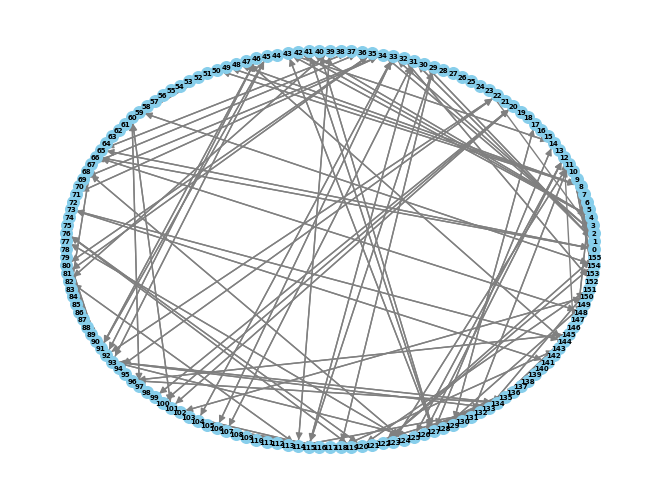

In [46]:
# Draw the graph
# pos = nx.spring_layout(G)  # positions for all nodes
pos = nx.circular_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=70, node_color='skyblue', font_size=5, font_color='black', font_weight='bold', edge_color='gray')
plt.show()


In [47]:
print(time_len, num_nodes)
print(data.shape, data1.shape)

1920 156
(1920, 156) (1920, 156)


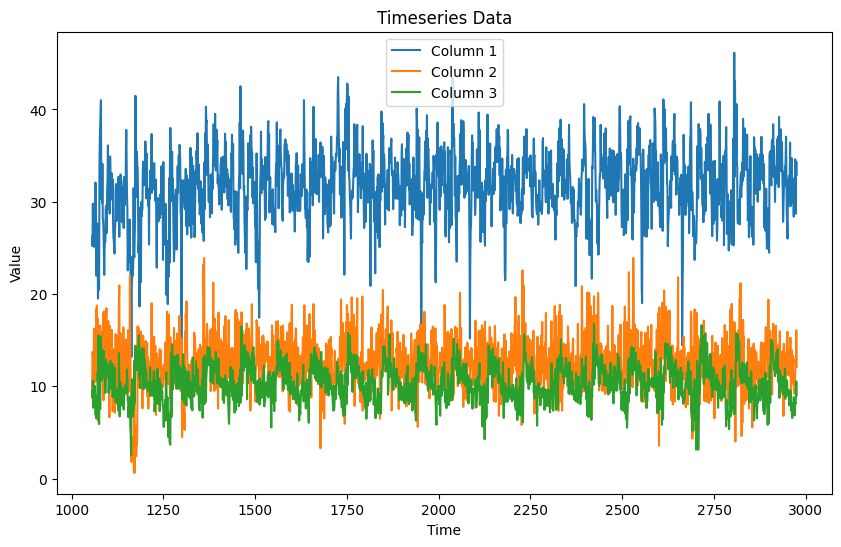

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Generate some sample data
# X = data[:,0]

# Plot all the columns of X in a single plot
plt.figure(figsize=(10, 6))  # Set the figure size

for i in range(3):  # Loop through each column of X
    plt.plot(data.iloc[:, i], label=f'Column {i+1}')  # Plot the column data with a label

plt.xlabel('Time')  # Set the x-axis label
plt.ylabel('Value')  # Set the y-axis label
plt.title('Timeseries Data')  # Set the title of the plot
plt.legend()  # Show the legend

plt.show()  # Show the plot


در این قسمت برای پیش بینی در بازه های زمانی آینده، برای هر مورد همه حالتهای تقسیم بندی داده ها
را ایجاد می کنیم.
مثلا برای اگر پیش بینی با

pre_len=2

مدنظر باشد، یک بار سطرهای فرد و یک بار سطرهای زوج از داده ها را انتخاب کرده
ماتریس دبلیو برای هر کدام تخمین زده شده و سپس اُر می کنیم.

In [49]:
%%time
W_true = adj

pred_list = [1]#[1,2,3,4]
num_nodes = data.shape[1]
for pre_len in pred_list:
    W_est_all = np.zeros((num_nodes,num_nodes,pre_len))
    for i in range(pre_len):
        X = data.values
        # Considering prediction length
        X = X[i::pre_len]
        model = DagmaLinear(loss_type='l2') # create a linear model with least squares loss
        w_est = model.fit(X, lambda1=0.02, w_threshold=0.2) # fit the model with L1 reg. (coeff. 0.02)
        W_est_all[:,:,i] = w_est

        acc = utils.count_accuracy(W_true, w_est > 0) # compute metrics of estimated adjacency matrix W_est with ground-truth
        print(pre_len, w_est.shape, acc, np.count_nonzero(w_est > 0))

    # adj_all = np.zeros(W_est_all.shape, dtype=int)
    # # Update values in adj based on the condition
    # adj_all[W_est_all > 0] = 1
    # adj = np.any(adj_all, axis=2)
    # print('adj.shape=', adj.shape)
    
    W_est_file_name = f"est_adj/W_est_{data_name}_preq_len{pre_len}.npy"
    # np.save(W_est_file_name, W_est_all)

  0%|          | 0/180000.0 [00:00<?, ?it/s]

1 (156, 156) {'fdr': 0.37104072398190047, 'tpr': 1.2575187969924813, 'fpr': 0.00709465305416162, 'shd': 209, 'nnz': 221} 221
CPU times: total: 2min 19s
Wall time: 1min 25s


with default w_threshold (0.3)
1 (156, 156) {'fdr': 0.18055555555555555, 'tpr': 1.218045112781955, 'fpr': 0.002249524139124416, 'shd': 174, 'nnz': 144} 144
CPU times: total: 7min 38s
Wall time: 6min 18s

In [50]:
adj_all = np.zeros(W_est_all.shape, dtype=int)
# Update values in adj based on the condition
adj_all[W_est_all > 0] = 1
adj = np.any(adj_all, axis=2)
W_est = adj.astype(int)
print('adj.shape=', adj.shape, type(adj[0,0]))
W_est_file_name = f"est_adj/W_est_{data_name}_pre_len{pre_len}.npy"
np.save(W_est_file_name, W_est_all)

adj.shape= (156, 156) <class 'numpy.bool_'>


In [51]:
pre_len = 1
W_est_file_name = f"est_adj/W_est_{data_name}_pre_len{pre_len}.npy"
W_est_all = np.load(W_est_file_name)
W_est_all.shape

(156, 156, 1)

In [52]:
adj_matrix = W_est_all[:,:,0]
dag = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

# Check if the graph is a DAG
is_dag = nx.is_directed_acyclic_graph(dag)

print("The graph is a DAG:", is_dag)

The graph is a DAG: True


In [53]:
adj = adj_matrix + adj_matrix.T
g2 = nx.from_numpy_array(adj)#, create_using=nx.DiGraph)

# Check if the graph is a DAG
is_dag = nx.is_directed_acyclic_graph(g2)

print("The graph is a DAG:", is_dag)

The graph is a DAG: False


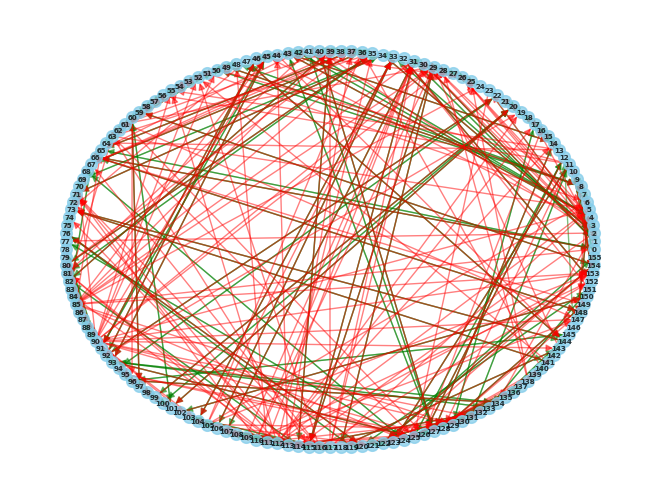

In [54]:
# Convert the numpy matrix to a NetworkX graph
# G = nx.from_numpy_matrix(adj_matrix, create_using=nx.DiGraph)

# Draw the graph
pos = nx.circular_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=70, node_color='skyblue', font_size=5, font_color='black', font_weight='bold', edge_color='green',alpha=0.5)

# pos = nx.spring_layout(dag)  # positions for all nodes
nx.draw(dag, pos, with_labels=True, node_size=70, node_color='skyblue', font_size=5, font_color='black', font_weight='bold', edge_color='red',alpha=.5)

plt.show()


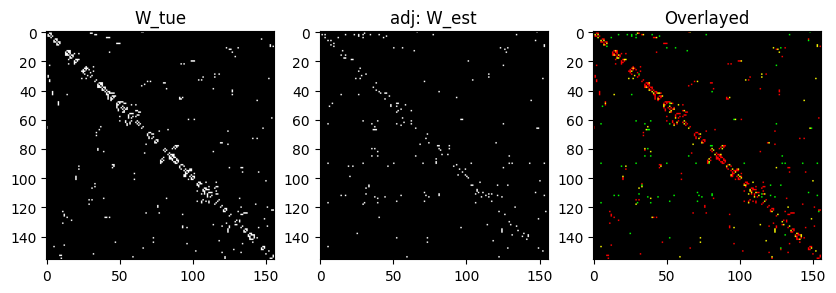

In [55]:
# W_true_normalized = (W_true - np.min(W_true)) / (np.max(W_true) - np.min(W_true)) * 255
# plt.imshow(W_true.astype(np.uint8), cmap='gray')
# plt.title(f'W True')
# plt.show()

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

axs[0].imshow(W_true.astype(np.uint8), cmap='gray')
axs[0].set_title('W_tue')

axs[1].imshow(W_est, cmap='gray')
axs[1].set_title('adj: W_est')

overlay_image = np.zeros((W_true.shape[0], W_true.shape[1], 3), dtype=np.uint8)
overlay_image[..., 0] = W_true * 255  # Red channel
overlay_image[..., 1] = W_est * 255   # Green channel

axs[2].imshow(overlay_image)
axs[2].set_title('Overlayed')

plt.show()

In [56]:
W_true.shape

(156, 156)

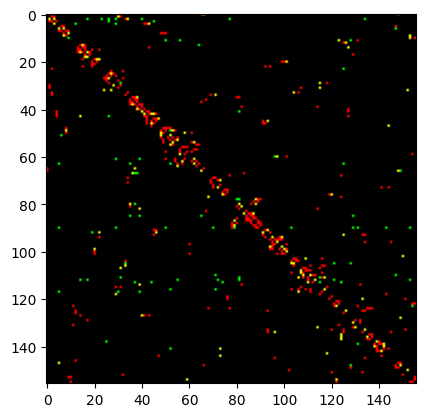

In [57]:
# W_est = adj.astype(int)
import numpy as np
import matplotlib.pyplot as plt

# Assuming W_true and W_est are numpy arrays of the same shape
# W_true = np.array(...) # Your actual data
# W_est = np.array(...) # Your actual data

# Create an RGB image where:
# - Red channel is W_true
# - Green channel is W_est
# - Blue channel is zeros (no contribution)
overlay_image = np.zeros((W_true.shape[0], W_true.shape[1], 3), dtype=np.uint8)
overlay_image[..., 0] = W_true * 255  # Red channel
overlay_image[..., 1] = W_est * 255   # Green channel

plt.imshow(overlay_image)
plt.show()



In [58]:

# num_preds = W_est_all.shape[2]
# # Generate a grid of subfigures
# num_cols = 2
# num_rows = num_preds // num_cols + 1

# fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 6))

# for i in range(num_preds):
#     row = i // num_cols
#     col = i % num_cols
#     ax = axes[row, col]
#     W_est = W_est_all[:,:,i]>0
#     # W_est_normalized = (W_est - np.min(W_est)) / (np.max(W_est) - np.min(W_est)) * 255
#     ax.imshow(W_est, cmap='gray')
#     ax.set_title(f'W_est pre_len={i+1}')
#     ax.axis('off')

# # plt.tight_layout()
# # plt.show()

# # # Convert to uint8
# # W_true_img = W_true_normalized.astype(np.uint8)
# # W_est_img = W_est_normalized.astype(np.uint8)

In [59]:
# import numpy as np
# W_est = np.load(W_est_file_name)
# type(W_est[0,0])

In [60]:
count = 0
for i in range(W_true.shape[0]):
    for j in range(W_true.shape[1]):
        if adj[i, j] > 0 and W_true[i, j] == 0:
            count += 1

print("Number of elements > 0 in W_est and equal to 0 in W_true:", count)

Number of elements > 0 in W_est and equal to 0 in W_true: 163
